In [144]:
from datetime import datetime
import re
import requests
import time

from matplotlib import dates as mpl_dates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [145]:
def time_request_predict(host_url):
    start = time.time()
    r = requests.post(
        f'{host_url}/predict',
        json={
            "age": 34, 
            "fnlwgt": 261799, 
            "education_num": 11, 
            "capital_gain": 0, 
            "capital_loss": 0, 
            "hours_per_week": 56
        }
    )
    end = time.time()
    return r, end-start


def time_request(host_url):
    start = time.time()
    r = requests.get(host_url)
    end = time.time()
    return r, end-start

In [147]:
# r, response_time = time_request('https://wrchvs35n6.execute-api.us-east-1.amazonaws.com/lambda_flask_ml')
r, response_time = time_request('https://yhju01gdah.execute-api.us-east-1.amazonaws.com/lambda_docker_flask_ml_s3')
# r, response_time = time_request('https://okxxo17i90.execute-api.us-east-1.amazonaws.com/lambda_docker_flask_ml')
# r, response_time = time_request('http://127.0.0.1:5000')

print(r)
print(response_time)

<Response [200]>
27.489510774612427


In [15]:
servers = {
    'zip': 'https://wrchvs35n6.execute-api.us-east-1.amazonaws.com/lambda_flask_ml',
    'docker_s3': 'https://yhju01gdah.execute-api.us-east-1.amazonaws.com/lambda_docker_flask_ml_s3',
    'docker_disk': 'https://okxxo17i90.execute-api.us-east-1.amazonaws.com/lambda_docker_flask_ml'
}

while True:
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}: Beginning requests...")
    for server_name, server_url in servers.items():
        for x in range(0, 10):
            request_at = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            r, response_time = time_request_predict(server_url)
            with open('predict_performance.csv', 'a') as f_out:
                # server,request_at,response_time_ms,response_status_code
                f_out.write(f"{server_name},{request_at},{response_time*1000:0.2f},{r.status_code}\n")
    time.sleep(7*60)

# Analyze Locust Performance Tests

In [135]:
txt = open('locust_logs/DOCKER_DISK_v1_locust_logs.txt').read()
txt = open('locust_logs/DOCKER_S3_v1_locust_logs.txt').read()
# txt = open('locust_logs/ZIP_v1_locust_logs.txt').read()
txt = open('locust_logs/DOCKER_DISK_v3_locust_logs.txt').read()
txt = open('locust_logs/DOCKER_DISK_v5_locust_logs.txt').read()

data = [
    {
        'request_at': re.search('\[(.*)\]',line).group(1),
        'response_time_ms': re.search('\s(\d{1,5}\.\d{2})$', line).group(1)
    } 
    for line in txt.split('\n') if '/root' in line
]

In [136]:
df = pd.DataFrame(data)
df['response_time_ms'] = df['response_time_ms'].astype(float)
df['request_at'] = pd.to_datetime(df['request_at'], format='%Y-%m-%d %H:%M:%S,%f')
df.sort_values('request_at').head()

,request_at,response_time_ms
0,2021-07-20 11:38:01.666,4827.43
1,2021-07-20 11:38:01.668,294.78
2,2021-07-20 11:38:01.678,198.65
3,2021-07-20 11:38:01.686,262.16
4,2021-07-20 11:38:01.687,5063.62


In [137]:
df.response_time_ms.describe()

count     1273.000000
mean       584.981854
std       1779.848964
min         65.310000
25%         75.440000
50%        109.910000
75%        150.770000
max      12641.510000
Name: response_time_ms, dtype: float64

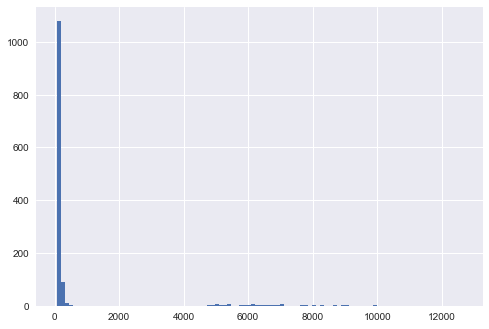

In [138]:
plt.hist(df.response_time_ms, bins=100);

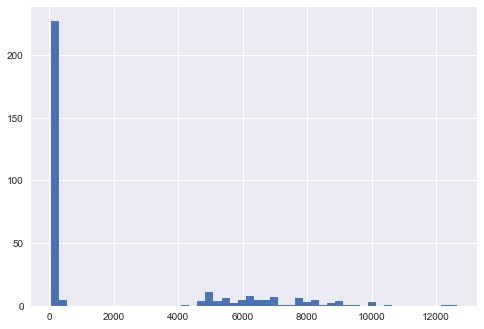

In [139]:
start_ts = df.request_at.min()
end_ts = df.request_at.min()

# first 15 seconds
plt.hist(df[df.request_at <= (start_ts + pd.Timedelta(seconds=15))].response_time_ms, bins=50);

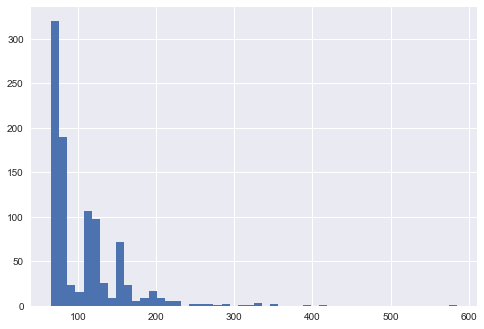

In [140]:
# after 15 seconds
plt.hist(df[df.request_at >= (start_ts + pd.Timedelta(seconds=15))].response_time_ms, bins=50);

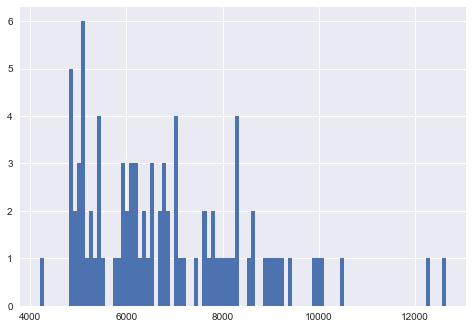

In [141]:
# cold starts
plt.hist(df[df.response_time_ms > 2000].response_time_ms, bins=100);

In [142]:
# https://stackoverflow.com/questions/17578115/pass-percentiles-to-pandas-agg-function
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

start_ts = df.request_at.min()

summary = (
#     df[df.request_at >= (start_ts + pd.Timedelta(seconds=15))]
    df
    .groupby(pd.Grouper(key='request_at', freq='5S'))
    .response_time_ms
    .agg(
        p50=percentile(50),
        p95=percentile(95),
        max_rt='max',
    )
    .reset_index()
)

summary

,request_at,p50,p95,max_rt
0,2021-07-20 11:38:00,5103.300,7707.1280,8073.86
1,2021-07-20 11:38:05,201.845,8982.9330,10488.97
2,2021-07-20 11:38:10,122.470,415.9580,12641.51
3,2021-07-20 11:38:15,114.840,203.8875,264.97
4,2021-07-20 11:38:20,108.730,192.0000,331.70
5,2021-07-20 11:38:25,86.080,206.2600,346.73
6,2021-07-20 11:38:30,78.950,165.5670,223.20
7,2021-07-20 11:38:35,82.055,200.6710,585.02
8,2021-07-20 11:38:40,78.470,176.4510,228.31
9,2021-07-20 11:38:45,76.880,193.6480,392.40


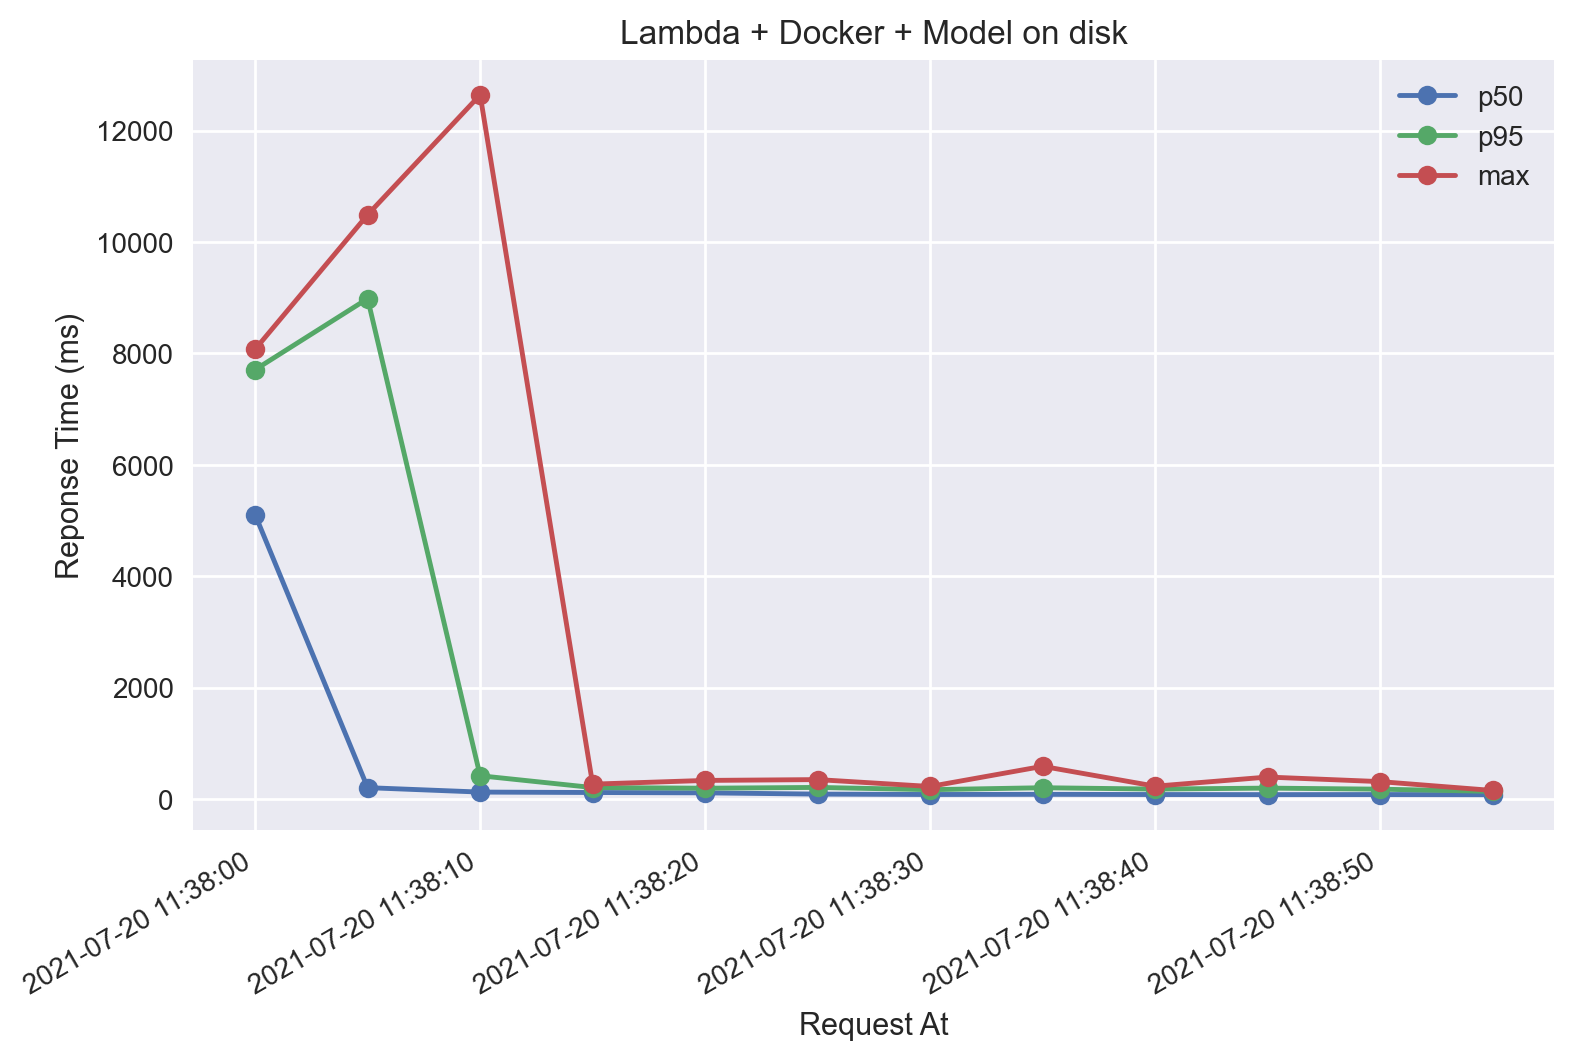

In [143]:
fig = plt.figure(figsize=(8, 5), dpi=200)


plt.plot_date(summary.request_at, summary.p50, linestyle='solid', label='p50')
plt.plot_date(summary.request_at, summary.p95, linestyle='solid', label='p95')
plt.plot_date(summary.request_at, summary.max_rt, linestyle='solid', label='max')
plt.legend()
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%Y-%m-%d %H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)

plt.tight_layout()
plt.title('Lambda + Docker + Model on disk')
plt.xlabel('Request At')
plt.ylabel('Reponse Time (ms)')
plt.show()